## Start

In [1]:
!nvidia-smi

Thu May 12 17:04:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
!mkdir -p drive
!google-drive-ocamlfuse drive

!ls
%cd drive/MyDrive/DLMI/STAS/ 
!ls

# !7z x all_data.7z

!pip install segmentation_models_pytorch
!pip install tqdm
!pip install wandb
!pip install albumentations==1.1.0
!pip install opencv-python-headless==4.1.2.30

Mounted at /content/drive
/bin/bash: google-drive-ocamlfuse: command not found
drive  sample_data
/content/drive/MyDrive/DLMI/STAS
all_data.7z  predictions   Public_Image.7z  Unet.ipynb
models	     Public_Image  Train	    Valid
     |████████████████████████████████| 88 kB 4.8 MB/s 
     |████████████████████████████████| 376 kB 16.7 MB/s 
     |████████████████████████████████| 58 kB 7.1 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=3e67dd3f752b7ea925c15e4d5582a938f391c95868165c11ebed18c2408b8f1c
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=e9bd349eea6abfb37eea14b0730f45eae05f680584eca0b68074d625da0a5785
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch 

## Import

In [4]:
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import json

## Dataset

In [5]:
DATA_DIR_train = './Train'
DATA_DIR_vail = './Valid'

In [6]:
x_train_dir = os.path.join(DATA_DIR_train, 'img')
y_train_dir = os.path.join(DATA_DIR_train,'label')

x_valid_dir = os.path.join(DATA_DIR_vail, 'img')
y_valid_dir = os.path.join(DATA_DIR_vail, 'label')


In [7]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 16))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import torch.nn.functional as F
import torch

In [9]:
import random

def fix_randomseed(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    # Cuda
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_randomseed(8863)

In [10]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['bg', 'stas']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        # self.masks_fps[i] = self.masks_fps[i].replace('.jpg','.png')
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if image.shape != (800, 800, 3):
            image = cv2.resize(image, (800, 800), interpolation=cv2.INTER_LANCZOS4)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        if mask.shape != (800, 800, 3):
            mask = cv2.resize(mask, (800, 800), interpolation=cv2.INTER_LANCZOS4)  
        mask = mask.astype('bool')
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

## Visualize

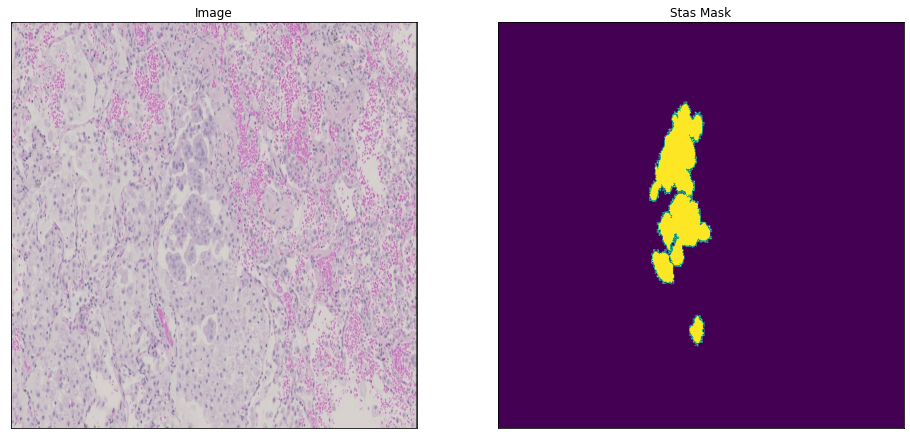

In [11]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['stas'])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    stas_mask=mask.squeeze(),
)

In [12]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.Rotate(limit=40,p=0.3,border_mode=cv2.BORDER_CONSTANT),
        albu.VerticalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0),
        
        albu.HueSaturationValue(p=0.6),
        albu.Sharpen(p=0.5),
        albu.RandomBrightnessContrast(p=0.4),

        albu.Crop(x_min=0, y_min=0, x_max=800, y_max=750, p=0.5),
        albu.PadIfNeeded(800, 800)

        
    ]
    return albu.Compose(train_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

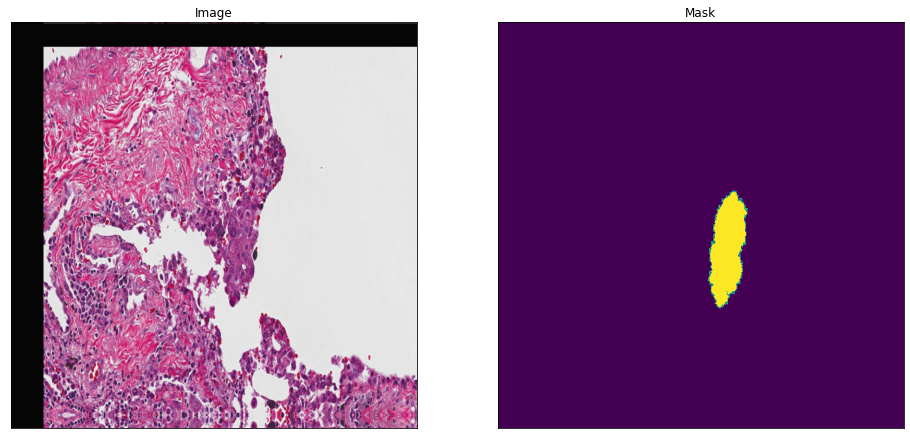

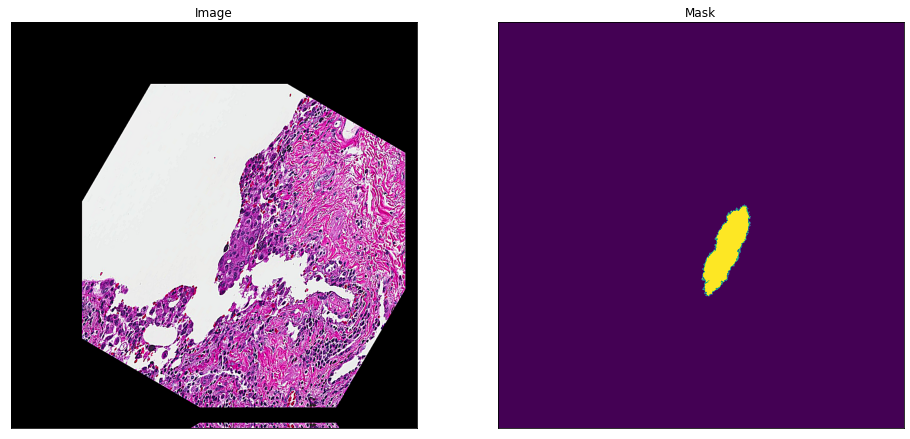

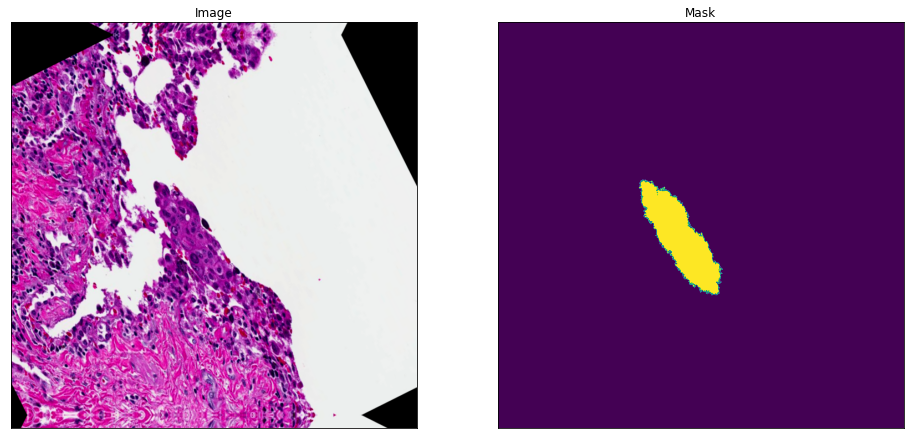

In [13]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['stas'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

## Create model and train

In [14]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
from torch import nn

In [15]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['stas']
ACTIVATION = 'sigmoid' 
DEVICE = 'cuda'



# create segmentation model with pretrained encoder
model = smp.MAnet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,

)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [16]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, pin_memory=True, batch_size=6, shuffle=True, num_workers=16)
valid_loader = DataLoader(valid_dataset, pin_memory=True, batch_size=6, shuffle=False, num_workers=16)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [17]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index
loss =smp.utils.losses.BCELoss()
# loss = smp.utils.losses.FocalLoss()
metrics = [
    smp.utils.metrics.Fscore(threshold=0.5),
]
init_lr = 3e-4
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=init_lr),
])

In [18]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [19]:
path='./models'
# os.makedirs(path)

In [22]:
max_score = 0

train_loss_list = []
train_fscore_list = []
valid_loss_list = []
valid_fcore_list = []


for i in range(100):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    train_loss_list.append(train_logs['bce_loss'])
    train_fscore_list.append(train_logs['fscore'])
    
    valid_loss_list.append(valid_logs['bce_loss'])
    valid_fcore_list.append(valid_logs['fscore'])
  

    if max_score < valid_logs['fscore']:
        max_score = valid_logs['fscore']
        torch.save(model, path+'/MAnet_resnet50_aug_bce.pth')
        print('Model saved!')
    if i >= 50:
        new_lr = init_lr * (1 - (i / 100))**0.9
        optimizer.param_groups[0]['lr'] = new_lr
        print(f'Decrease decoder learning rate to {new_lr:.5f}!')


Epoch: 0
train:   0%|          | 0/156 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train:   0%|          | 0/156 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.




Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-e45720523e81>", line 11, in <module>
    train_logs = train_epoch.run(train_loader)
  File "/usr/local/lib/python3.7/dist-packages/segmentation_models_pytorch/utils/train.py", line 45, in run
    for x, y in iterator:
  File "/usr/local/lib/python3.7/dist-packages/tqdm/std.py", line 1195, in __iter__
    for obj in iterable:
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 530, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1224, in _next_data
    return self._process_data(data)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1250, in _process_data
    data.reraise()
  File "/usr/local/lib/python3.7/dist-packages/torch/

error: ignored

In [ ]:
plt.figure(0)
plt.plot(train_fscore_list)
plt.plot(valid_fcore_list)
plt.title('Train Logs')      
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')

plt.figure(1)
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.title('Train Logs')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')


plt.show()

In [ ]:
# load best saved checkpoint
best_model = torch.load('./models/MAnet_resnet50_aug_bce.pth')

## Backup

In [ ]:
# test_dataset = Dataset(
#     x_test_dir, 
#     y_test_dir, 
#     preprocessing=get_preprocessing(preprocessing_fn),
#     classes=CLASSES,
# )

# test_dataloader = DataLoader(test_dataset)

In [ ]:
# # evaluate model on test set
# test_epoch = smp.utils.train.ValidEpoch(
#     model=best_model,
#     loss=loss,
#     metrics=metrics,
#     device=DEVICE,
# )

# logs = test_epoch.run(test_dataloader)

In [ ]:
# # test dataset without transformations for image visualization
# test_dataset_vis = Dataset(
#     x_test_dir, y_test_dir, 
#     classes=CLASSES,
# )

In [ ]:

# for i in range(len(test_dataset_vis)):
#     name = os.path.basename(test_dataset_vis.masks_fps[i])
#     print(name)
#     image_vis = test_dataset_vis[i][0].astype('uint8')
#     image, gt_mask = test_dataset[i]
#     x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
#     pr_mask = best_model.predict(x_tensor)
#     pr_mask = (pr_mask.squeeze().cpu().numpy().round())
#     len(pr_mask)
# #     print(gt_mask.shape)
#     zeros = np.zeros((800, 800, 3))
#     zeros[...,0] = pr_mask
#     zeros = cv2.resize(zeros, (1920, 828))
# #     print(i)
#     visualize( 
#             image=image_vis, 
#             ground_truth_mask=gt_mask.transpose(1, 2, 0)[...,0], 
#             predicted_mask=pr_mask
#         )
# #     plt.imshow(zeros)
# #     plt.show()
# #     print(os.path.join(out_path, name.replace('.jpg','.png')))
# #     plt.imsave(os.path.join(out_path, name.split.replace('.jpg','.png'), zeros))
    

## Test

In [ ]:
out_path='./predictions/MAnet_resnet50_bce/'
os.makedirs(out_path, exist_ok=True)

In [ ]:
# !7z x Public_Image.7z

In [ ]:
public_dir = './Public_Image/'

In [ ]:
class PublicDataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['bg', 'stas']
    
    def __init__(
            self, 
            images_dir,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        # self.masks_fps[i] = self.masks_fps[i].replace('.jpg','.png')
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if image.shape != (800, 800, 3):
            image = cv2.resize(image, (800, 800), interpolation=cv2.INTER_LANCZOS4)

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']
            
        return image
        
    def __len__(self):
        return len(self.ids)

In [ ]:
public_dataset = PublicDataset(
    public_dir, 
    preprocessing=get_preprocessing(preprocessing_fn)
)


In [ ]:
for i in range(len(public_dataset)):
    name = os.path.basename(public_dataset.images_fps[i])
    print(name)
    image_vis = public_dataset[i][0]#.astype('uint8')
    image = public_dataset[i]
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    len(pr_mask)
#     print(gt_mask.shape)
    zeros = np.zeros((800, 800, 3))
    zeros[...,0] = pr_mask
    zeros[...,1] = pr_mask
    zeros[...,2] = pr_mask
    zeros = cv2.resize(zeros, (1716, 942))
#     print(i)
    visualize( 
            image=image_vis, 
            predicted_mask=pr_mask
        )
    plt.imshow(zeros)
    plt.show()
    print(os.path.join(out_path, name.replace('.jpg','.png')))
    plt.imsave(os.path.join(out_path, name.replace('.jpg','.png')), zeros)